In [1]:
import numpy as np
import pandas as pd
from dython.nominal import associations
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomTreesEmbedding, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
#from sklearn.inspection import permutation_importance
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# read the files
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

# initialize dictionaries. Keys are the model names
model_dict = {}
reformat_dict = {}
categories_dict = {}
log_dict = {}

In [3]:
# this data reformat function is shared by all models and exceuted beforehand
# I assume we know the test set in advance
def shared_reformat(df):
    df = deepcopy(df)
    
    # create special targets (only on train set)
    if "max_price" in list(df):
        df["delta_abs"] = df["max_price"] - df["min_price"] 
        df["delta_rel"] = np.log(df["max_price"] / df["min_price"] )
    
    # deal with missing data
    #df.pixels_y = df.pixels_y.fillna(0)
    df.detachable_keyboard.fillna(0, inplace = True)  # only four cases. Assume none
    df.pixels_x.fillna(1920, inplace = True)   # only 2 cases, replace by most common value
    df.pixels_y.fillna(1080, inplace = True)   # only 2 cases, replace by most common value
    df.loc[df.screen_surface.isna(), "screen_surface"] = 'Glossy'       # 12 cases, large majority is Glossy,
    df.loc[df.screen_surface.isna() & df.pixels_x == 1920, "screen_surface"] = 'Matte'  # except here
    df.sort_values(by=['name'])
    df.cpu_details.fillna(method='bfill', inplace=True)  # take previous value, they are often similar
    df.gpu.fillna(method='bfill', inplace=True)  # take previous value, they are often similar
    df.weight.fillna(method='bfill', inplace=True)
    df.loc[df.os.isna() & df.brand == "Apple", "os"] = 'macOS'  # 1 case
    df.loc[df.os_details.isna() & df.brand == "Apple", "os_details"] = "macOS Mojave"  # 1 case, most common
    df.loc[df.os.isna() & df.brand == "Dell", "os"] = 'Windows'  # 1 case
    df.loc[df.os_details.isna() & df.brand == "Dell", "os_details"] = "Windows 10 Home"  # 1 case, most common
    

    # create new features
    df["cpu_brand"] = df.cpu.str.split(n=1).str[0]
    df["cpu_type"] = df.cpu.str.split(n=1).str[1]
    df["gpu_brand"] = df.gpu.str.split(n=1).str[0]
    df["gpu_series"] = df.gpu.str.split(n=2).str[1]
    df["os_type"] = df.os_details.str.split(n=1).str[1]
    df["os_nr"] = df.os_details.str.split(n=2).str[2]
    df["resolution"] = df.pixels_y / df.screen_size
    df["gimmick"] = df.detachable_keyboard + 5 * df.discrete_gpu + 3* df.touchscreen
    def get_speed(sentence):
        try:
            sentence = sentence.split()
            index = sentence.index('GHz')
            return pow(float(sentence[index-1]),2)
        except:
            return pow(2.4, 2)
    df["speed"] = df.cpu_details.apply(get_speed)
    def has_word(sentence, word):
        try:
            return word in sentence
        except:
            return False
    df["Dual-Core"] = df.cpu_details.apply(has_word, word="Dual-Core")
    df["Quad-Core"] = df.cpu_details.apply(has_word, word="Quad-Core")
    df["Hexa-Core"] = df.cpu_details.apply(has_word, word="Hexa-Core")
    df["Hyper-Threading"] = df.cpu_details.apply(has_word, word="Hyper-Threading")
    
    
    # correct a few mistakes in new features
    map_gpu_series = {"GeFoce":"GeForce", "RadeonÂ": "Radeon"}
    df.gpu_series = df.gpu_series.replace(map_gpu_series) 
    map_screen_surface = {"glossy":"Glossy", "matte":"Matte"}
    df.screen_surface = df.screen_surface.replace(map_screen_surface)  

    
    # make sure all values in categorical variables are strings
    cat_col = df.select_dtypes(include=['object']).columns
    df[cat_col] = df[cat_col].astype(str)
    
    # skewedness
    #numeric_feats = df.dtypes[df.dtypes != "object"].index
    #from scipy.stats import skew
    #skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    #skewness = pd.DataFrame({'Skew' :skewed_feats})
    #print(skewness)
    #skewness = skewness[abs(skewness) > 2]
    #from scipy.special import boxcox1p
    #skewed_features = skewness.index
    #skewed_features = [x for x in skewed_features if x not in ["max_price", "min_price", "delta_abs", "delta_rel"]]
    #lam = 0.15
    #for feat in skewed_features:
    #    print("bj", feat)
    #    df[feat] = boxcox1p(df[feat], lam)
                                                 
    # cleanup test set
    df.pixels_y = df.pixels_y.astype('int64')
    
    # shuffle the database
    df.sample(frac=1)
    
    return df

In [4]:
df_train["set"] = "train"
df_test["set"] = "test"
df_complete = pd.concat([df_train,df_test], join='outer', axis=0, sort=False)
df_complete = shared_reformat(df_complete)
df_train = df_complete[df_complete.set == "train"].drop(columns=["set"])
df_test = df_complete[df_complete.set == "test"].drop(columns=["set"])
print(len(df_train), len(df_test))

510 222


C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [5]:
# I no longer use delta_abs and delta_rel but they keep trailing in the functions
targets = ["max_price", "delta_abs", "delta_rel", "min_price"]

In [6]:
# prepares the regressor and X values for a model
def prepare_model(model, df, target, log, verbose=True):
    vprint = print if verbose else lambda *a, **k: None
    df_pp = reformat_dict[model](df)
    X = df_pp.drop(targets, axis=1)
    categories = categories_dict[model]
    preprocessor = create_preprocessor(X, categories)
    input_shape = Pipeline([('tp', preprocessor)]).fit_transform(X).shape[1]
    vprint("nr of features=", input_shape)
    regressor = model_dict[model](preprocessor, input_shape)
    if log: regressor = TransformedTargetRegressor(regressor=regressor, func=np.log, inverse_func=np.exp)
    return X, regressor

In [7]:
# With this function, models are tested in 10-fold cross_validation and
# a permutation variance analysis is performed
def test_model(model, df, target = "max_price", log=True, nr_folds=10):
    Y = df[target]
    X, regressor = prepare_model(model, df, target, log)
    scores = cross_validate(regressor, X, Y, scoring=['neg_mean_absolute_error'], cv=nr_folds)
    print("gemiddeld: {}, details: {}".format(-np.mean(scores['test_neg_mean_absolute_error']), -scores['test_neg_mean_absolute_error']))
    regressor.fit(X, Y)
    var_importance(regressor, X, Y)

In [8]:
# computes all levels for all categorical variables
# that a give model uses. Takes both training and
# test set into account (we know the test set)

def get_categories(df_train, df_test, reformater):
    # compute levels categorical variables for Huber
    train_df = reformater(df_train)
    train_df = train_df.drop(columns=targets)
    test_df = reformater(df_test)
    categorical_features = test_df.select_dtypes(include=['object']).columns
    df_full = pd.concat([train_df,test_df], join='outer', axis=0)
    categories = []
    for col in categorical_features:
        categories.append(df_full[col].unique())
    return categories

In [9]:
## HUBER ##
def reformat_huber(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.ssd = df.ssd.pow(1)  #square the values
    df.weight = np.maximum(0,np.log(df.weight+.0000001)) 
    df["wstorage"] = df.storage.pow(1.5)
    
    # drop columns
    drop_cols = ["touchscreen", "screen_surface", "gpu_series", "ram", "detachable_keyboard", "os",
                "pixels_y", "os_type", "os_nr", "id", "pixels_x", "gpu_brand", "name", "cpu_type",
                "weight", "storage", "cpu_brand", "os_details"]
    # previous best 
    drop_cols = ["id", "name", "screen_size", "weight", "gpu_series", "base_name", 
                "detachable_keyboard", "ram", "screen_surface", "storage", "Quad-Core","os_details",
                "speed", "cpu_details", "os", "pixels_x", "cpu_details", "touchscreen", "cpu_type",
                "gimmick"]
    #best performer v3
    drop_cols = ["touchscreen", "screen_surface", "gpu_series", "ram", "detachable_keyboard", "os",
            "pixels_y", "os_type", "os_nr", "id", "pixels_x", "gpu_brand", "name", "cpu_type",
            "Dual-Core"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other"
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        val_counts = df[col].value_counts(normalize=True).cumsum()
        val_counts = val_counts.where(val_counts < .95)
        keep_vals = list(val_counts.dropna().index.values)
        df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["huber"] = reformat_huber
categories_dict["huber"] =  get_categories(df_train, df_test, reformat_huber)
log_dict["huber"] = False

def pipe_huber(preprocessor, input_shape):
    pipeline = Pipeline([
                    (('preprocessor', preprocessor)),
                    #('uma', umap.UMAP(n_components=15, n_neighbors=10, n_epochs=100)),
                    #('tsv', TruncatedSVD(n_components=1000)),
                     ('rdg', HuberRegressor(1.7, alpha=.020, max_iter=5000)) #alpha:regulizer
                    ])
    return pipeline


model_dict["huber"] = pipe_huber

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [10]:
## RANDOM FOREST REGRESSOR ##
def reformat_rfr(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "gpu_series", "pixels_x", "screen_surface", "os", "os_details", "cpu_brand",
              "detachable_keyboard", "touchscreen", "os_nr", "screen_size", "cpu_details", "brand",
              "gpu_brand", "os_type", "storage"]
    drop_cols=["id", "name", "base_name", "screen_size", "weight", "detachable_keyboard", "gpu_series",
              "ssd", "pixels_x", "cpu_details", "os_details", "cpu_brand", "cpu", "os"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["rfr"] = reformat_rfr
categories_dict["rfr"] =  get_categories(df_train, df_test, reformat_rfr)
log_dict["rfr"] = True

def pipe_rfr(preprocessor, input_shape):
    pipeline= Pipeline([
                    (('preprocessor', preprocessor)),
                     ('rfr', RandomForestRegressor(criterion="mse", max_features = .2, n_jobs=-1,
                                                   min_samples_leaf=1, max_depth=20, n_estimators=500))
     ])
    return pipeline
model_dict["rfr"] = pipe_rfr

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [11]:
## GRADIENT BOOSTING REGRESSOR ##
def reformat_gbr(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "detachable_keyboard", "base_name"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["gbr"] = reformat_gbr
categories_dict["gbr"] =  get_categories(df_train, df_test, reformat_gbr)
log_dict["gbr"] = True

def pipe_gbr(preprocessor, input_shape):
    pipeline= Pipeline([
                    (('preprocessor', preprocessor)),
                     ('3rd', GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=1, min_samples_split=5, 
                                   loss='huber', random_state =5))
                    ])
    return pipeline

model_dict["gbr"] = pipe_gbr

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [12]:
## SUPPORT VECTOR MACHINE ##
def reformat_svm(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "detachable_keyboard", "base_name", "pixels_x", "os_details", "cpu",
              "cpu_details", "cpu_brand", "os", "screen_surface", "os_nr"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["svm"] = reformat_svm
categories_dict["svm"] =  get_categories(df_train, df_test, reformat_svm)
log_dict["svm"] = True

def pipe_svm(preprocessor, input_shape):
    
    pipeline = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('3rd', SVR())
                        ])
    return pipeline

model_dict["svm"] = pipe_svm

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [13]:
## K NEIGHBORS REGRESSOR ##
def reformat_knr(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "detachable_keyboard", "base_name", "pixels_x", "cpu_details", "os", "gimmick",
              "os_type", "os_details", "Dual-Core", "discrete_gpu", "cpu_brand"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["knr"] = reformat_knr
categories_dict["knr"] =  get_categories(df_train, df_test, reformat_knr)
log_dict["knr"] = True

def pipe_knr(preprocessor, input_shape):
    
    pipeline = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('knr', KNeighborsRegressor(n_neighbors=3, leaf_size=10, p=1, weights='distance'))
                        ])
    return pipeline

model_dict["knr"] = pipe_knr

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [14]:
# neural network imports
from sklearn.base import TransformerMixin
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers
from keras.regularizers import l1_l2
from keras.models import load_model

class MLP_custom(TransformerMixin):
    def __init__(self, nodes=5, epochs=200, batch_size=60, metric='mean_absolute_error', l1=0.0001, l2=0.0001,
                 input_shape=0, validation_split=.3, patience=3):
        self.nd = nodes
        self.ep = epochs
        self.bs= batch_size
        self.metric = metric
        self.l1 = l1
        self.l2 = l2
        self.vs = validation_split
        self.pat = patience
        
        # model
        inputs = Input(shape=(input_shape,))  # was 1196
        dense = Dense(self.nd, activity_regularizer=l1_l2(self.l1, self.l2), 
                      activation="relu", kernel_initializer='Orthogonal')(inputs)
        output = Dense(1, activation="relu")(dense)
        self.model = Model(inputs=inputs, outputs=output)
        self.model.compile(loss = self.metric, optimizer = 'adadelta', metrics=[self.metric])
        
        #callbacks
        self.es = EarlyStopping(monitor='val_'+metric, mode='min', verbose=0, patience=self.pat)
        self.mc = ModelCheckpoint('best_model.h5', monitor='val_'+metric, mode='min', verbose=0, save_best_only=True)
        
        
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.model.fit(X, Y, epochs=self.ep, batch_size=self.bs, callbacks=[self.es, self.mc], 
                       validation_split=self.vs, verbose=0)    
        self.model = load_model('best_model.h5')

    
    def transform(self, X):
        return self.model.predict(X)
    
    
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, Y):
        self.X = X
        self.Y = Y
        self.Y_pred = self.model.predict(X)
        return mean_absolute_error(self.Y, self.Y_pred)


Using TensorFlow backend.


In [15]:
## MULTI LAYER PERCEPTRON##
def reformat_mlp(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "detachable_keyboard", "base_name", "pixels_x"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["mlp"] = reformat_mlp
categories_dict["mlp"] =  get_categories(df_train, df_test, reformat_mlp)
log_dict["mlp"] = True

def pipe_mlp(preprocessor, input_shape):
    
    pipeline = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('mlp', MLP_custom(input_shape=input_shape, nodes=10))
                        ])
    return pipeline

model_dict["mlp"] = pipe_mlp

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [16]:
# this preprocessor is the same for all models, but doesn't have to be
def create_preprocessor(df_pp, categories):
    #global categories
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
        ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        #('ordinal', OrdinalEncoder(categories=categories)),
        #('scaler', StandardScaler())
        ('onehot', OneHotEncoder(categories=categories, handle_unknown="ignore")),   
        ])

    numeric_features = df_pp.select_dtypes(include=['int64', 'float64', 'boolean']).columns
    categorical_features = df_pp.select_dtypes(include=['object']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor

In [17]:
## RANSAC ##
from sklearn.linear_model import RANSACRegressor
def reformat_ran(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "detachable_keyboard", "base_name", "pixels_x", "cpu_details", "os", "gimmick",
              "os_type", "os_details", "Dual-Core", "discrete_gpu", "cpu_brand", "Hexa-Core", "screen_surface",
              "weight", "Quad-Core", "touchscreen", "ram", "cpu", "speed", "resolution", "storage", "gpu_brand"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["ran"] = reformat_ran
categories_dict["ran"] =  get_categories(df_train, df_test, reformat_ran)
log_dict["ran"] = True

def pipe_ran(preprocessor, input_shape):
    
    pipeline = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('ran', RANSACRegressor())
                        ])
    return pipeline

model_dict["ran"] = pipe_ran

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [18]:
## SGD ##
from sklearn.linear_model import SGDRegressor
def reformat_sgd(df):
    df = deepcopy(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    # drop columns
    drop_cols=["id", "name", "detachable_keyboard", "base_name", "pixels_x", "gimmick", "touchscreen",
              "screen_surface", "gpu_brand", "os_details", "cpu", "Hexa-Core", "ram", "storage",
              "pixels_y", "speed", "Hyper-Threading", "os_type", "gpu_series", "Dual-Core"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other": doesn't seem to help
    #cat_col = df.select_dtypes(include=['object']).columns
    #for col in cat_col:
    #    val_counts = df[col].value_counts(normalize=True).cumsum()
    #    val_counts = val_counts.where(val_counts < .99)
    #    keep_vals = list(val_counts.dropna().index.values)
    #    df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

reformat_dict["sgd"] = reformat_sgd
categories_dict["sgd"] =  get_categories(df_train, df_test, reformat_sgd)
log_dict["sgd"] = True

def pipe_sgd(preprocessor, input_shape):
    
    pipeline = Pipeline([
                        (('preprocessor', preprocessor)),
                         ('sgd', SGDRegressor(loss='squared_loss', penalty='l1', alpha=0.0001, max_iter=5000))
                        ])
    return pipeline

model_dict["sgd"] = pipe_sgd

C:\Users\u0115374\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [19]:
# permutation variable importance
def var_importance(pipe, X, Y, scoring=None):
    perm_imp = permutation_importance(pipe, X, Y, scoring=scoring, n_repeats=10, n_jobs=None, random_state=None)
    sorted_idx = perm_imp.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(perm_imp.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()

In [20]:
test_model("sgd", df_train, target="max_price", log=False, nr_folds=10)

TypeError: data type "boolean" not understood

In [21]:
test_model("sgd", df_train, target="min_price", log=False, nr_folds=10)

TypeError: data type "boolean" not understood

nr of features= 157
gemiddeld: 175.42549782032356, details: [188.95225663 194.97725446 183.61049541 155.19253782 175.67642184
 184.25456286 194.86635641 152.64853437 196.55274247 127.52381593]


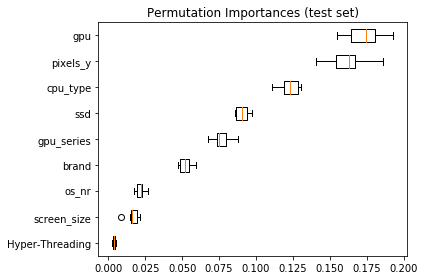

In [386]:
test_model("ran", df_train, target="max_price", log=False, nr_folds=10)

nr of features= 157
gemiddeld: 178.0115374175391, details: [162.75020294 225.82935705 126.21896369 169.88615054 167.95815545
 166.1341621  187.01728165 175.12795047 256.78997349 142.4031768 ]


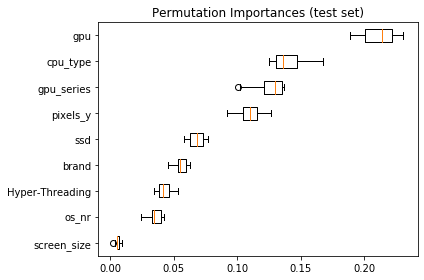

In [387]:
test_model("ran", df_train, target="min_price", log=False, nr_folds=10)

nr of features= 412
gemiddeld: 183.91060283346738, details: [194.53317417 183.99491533 173.203719  ]


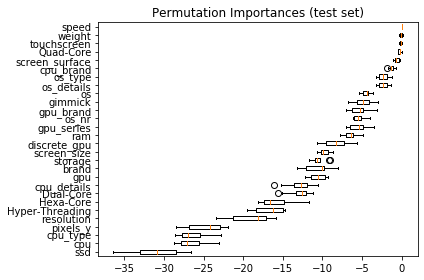

In [315]:
test_model("mlp", df_train, target="max_price", log=False, nr_folds=3)
# patience! This takes a few minutes...
# very strange permutation importances (all negative)

nr of features= 175
gemiddeld: 152.44498601106892, details: [ 97.00999962 218.0773104  151.56210661 130.32068511 171.52063376
 162.82315067 126.93171879 129.12247025 205.61826998 131.46351492]


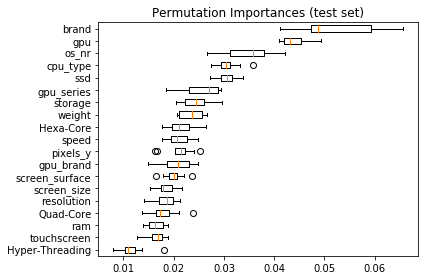

In [233]:
test_model("knr", df_train, target="max_price", log=True)

nr of features= 175
gemiddeld: 151.91610091013965, details: [108.80322648 212.05057044 152.43100819 131.69120186 166.77191511
 154.79403522 133.01059356 125.55313773 205.19628948 128.85903104]


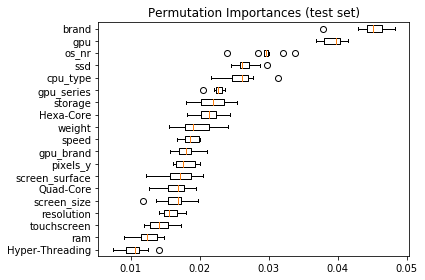

In [231]:
test_model("knr", df_train, target="max_price", log=False)

nr of features= 185
gemiddeld: 146.39535897490603, details: [128.86736998 198.95034015 137.22208664 130.41532195 150.01425403
 158.84858007 132.03744141 122.25116411 179.44563464 125.90139677]


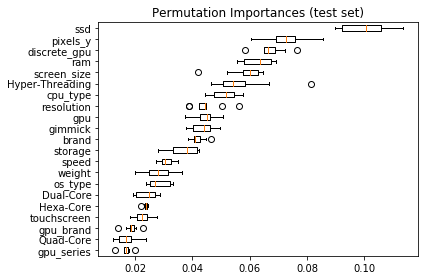

In [83]:
test_model("svm", df_train, target="max_price", log=True)

nr of features= 185
gemiddeld: 139.83376965575283, details: [125.03785701 189.77263379 119.65308192 127.92071551 133.21785662
 144.10758927 139.61419856 111.59941576 176.99091303 130.42343509]


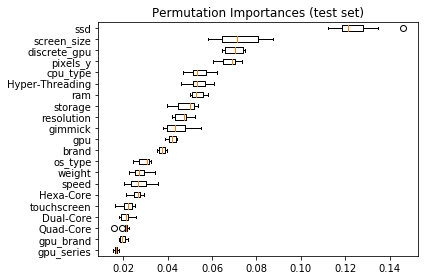

In [43]:
test_model("svm", df_train, target="min_price", log=True)

nr of features= 413
gemiddeld: 137.76782731388332, details: [ 97.40321267 192.38044222 124.78652456 126.70012481 161.74390995
 153.46035866 122.54653289 124.72536183 168.67077324 105.26103231]


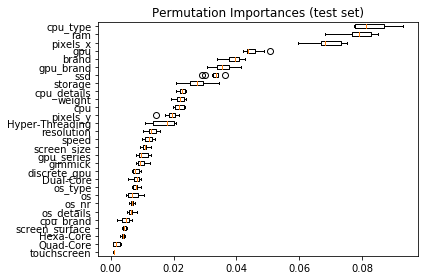

In [146]:
test_model("gbr", df_train, target="max_price", log=True)

c:\users\hans\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


nr of features= 413
gemiddeld: 135.06789288963284, details: [ 94.77516641 195.94096115 115.77819387 122.85093404 149.53797941
 143.28383709 134.92207385 119.73680104 167.57572303 106.277259  ]


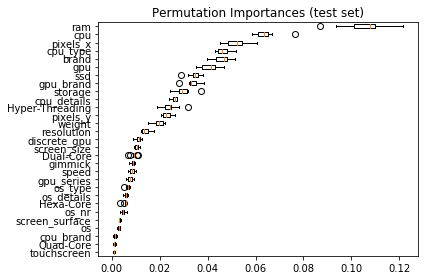

In [26]:
test_model("gbr", df_train, target="min_price", log=True)

c:\users\hans\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


nr of features= 187
gemiddeld: 145.33147791270582, details: [103.87242024 215.11674759 128.32031557 139.89619145 149.56658165
 141.88335412 130.65437622 138.37654286 197.44293108 108.18531832]


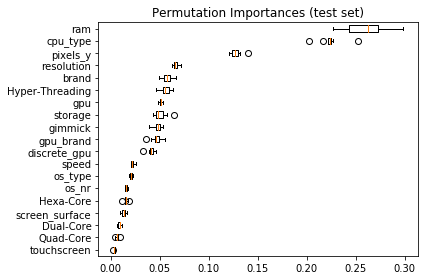

In [20]:
test_model("rfr", df_train, target="max_price", log=True)

c:\users\hans\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


nr of features= 187
gemiddeld: 138.20318714727964, details: [102.35392979 209.31747894 104.40532481 129.71163067 134.07845038
 130.74642247 133.92602779 126.1397913  197.49558414 113.85723119]


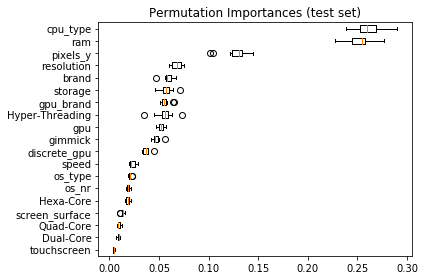

In [21]:
test_model("rfr", df_train, target="min_price", log=True)

c:\users\hans\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()


nr of features= 723
gemiddeld: 152.23769571947395, details: [124.20295928 178.45524106 157.75308386 139.54251535 160.15242969
 155.72477782 153.07454598 137.53201264 179.43595045 136.50344107]


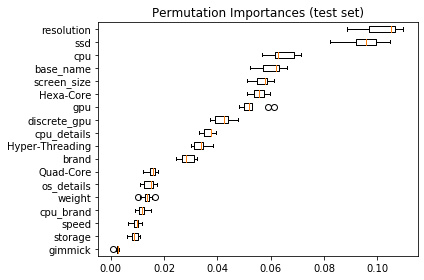

In [18]:
test_model("huber", df_train, target="max_price", log=False)

c:\users\hans\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
c:\users\hans\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()


nr of features= 723
gemiddeld: 147.1575129743022, details: [123.78103075 173.004275   140.25640363 136.34449775 144.61238018
 139.43777982 151.74639019 129.56044399 187.32254132 145.5093871 ]


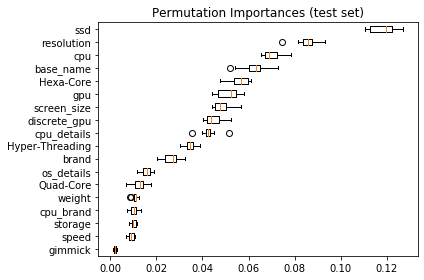

In [19]:
test_model("huber", df_train, target="min_price", log=False)

In [127]:
# Huber regression to compuet optimal shares between models
def find_shares(df):
    X = df.drop(columns=["Y"])
    Y = df["Y"]
    reg =  HuberRegressor() #2, alpha=.9, max_iter=50000)
    reg.fit(X,Y)
    shares = reg.coef_
    return shares

In [523]:
# 10-fold cross-validation that automatically determine optimal shares of respective models
def ensemble_test(df, target, reformat_dict, categories_dict, log_dict, learners, verbose=True):
    vprint = print if verbose else lambda *a, **k: None
    N = 10 
    kf = KFold(n_splits=N)
    df_res_full = pd.DataFrame()
    
    for train, val in kf.split(df):
        Y_train = df[target].iloc[train]
        Y_val = df[target].iloc[val]
        df_res = pd.DataFrame()
        df_res["Y"] = np.array(Y_val)
        #learners_error = []
        for learner in learners:
            X, regressor = prepare_model(learner, df, target, log=log_dict[learner], verbose=False)
            X_train = X.iloc[train]
            X_val = X.iloc[val]
            regressor.fit(X_train, Y_train)
            df_res[learner] = regressor.predict(X_val)
            learner_error = mean_absolute_error(df_res["Y"], df_res[learner])
            vprint("{}: {:.2f}".format(learner, learner_error), end='; ')  
            
        df_res_full = pd.concat([df_res_full, df_res], join='outer', axis=0)
        vprint("")        
    
    # find optimal shares for each learner
    shares = find_shares(df_res_full)
    df_res_full["ensemble"] = 0
    
    # compute results
    for learner, share in zip(learners, shares):
        df_res_full["ensemble"] += share * df_res_full[learner]
        learner_error = mean_absolute_error(df_res_full["Y"], df_res_full[learner])
        vprint("avg. {}: {:.2f}, share: {:.2f}".format(learner, learner_error, share)) 
    ens_error = mean_absolute_error(df_res_full["Y"], df_res_full["ensemble"])
    vprint("avg. ensemble: {:.2f}".format(ens_error))
    vprint("")
    
    return ens_error, shares

ens_max, share_max = ensemble_test(df_train, "max_price", reformat_dict, categories_dict, log_dict,
                                                     learners=["huber", "rfr", "svm", "gbr", "knr"], verbose=True)
ens_min, share_min = ensemble_test(df_train, "min_price", reformat_dict, categories_dict, log_dict,
                                                     learners=["huber", "rfr", "svm", "gbr", "knr"], verbose=True)
print("Seppe error = {:.2f}".format(ens_max+ens_min))

huber: 120.62; rfr: 102.76; svm: 128.87; gbr: 97.40; knr: 101.17; 
huber: 178.95; rfr: 215.25; svm: 198.95; gbr: 192.38; knr: 219.81; 
huber: 156.10; rfr: 128.76; svm: 137.22; gbr: 124.79; knr: 152.20; 
huber: 137.78; rfr: 140.38; svm: 130.42; gbr: 126.70; knr: 120.39; 
huber: 159.52; rfr: 152.04; svm: 150.01; gbr: 161.74; knr: 166.28; 
huber: 156.10; rfr: 141.18; svm: 158.85; gbr: 153.46; knr: 175.15; 
huber: 155.58; rfr: 129.71; svm: 132.04; gbr: 122.55; knr: 119.14; 
huber: 137.30; rfr: 139.07; svm: 122.25; gbr: 124.73; knr: 131.60; 
huber: 176.83; rfr: 194.90; svm: 179.45; gbr: 168.67; knr: 206.72; 
huber: 134.69; rfr: 109.35; svm: 125.90; gbr: 105.26; knr: 125.90; 
avg. huber: 151.35, share: 0.23
avg. rfr: 145.34, share: -0.13
avg. svm: 146.40, share: 0.17
avg. gbr: 137.77, share: 0.56
avg. knr: 151.84, share: 0.18
avg. ensemble: 133.71

huber: 119.82; rfr: 102.00; svm: 125.04; gbr: 94.78; knr: 107.47; 
huber: 174.90; rfr: 206.63; svm: 189.77; gbr: 195.94; knr: 209.55; 
huber: 138

CREATE CSV FOR SEPPE

In [524]:
# compute results on test set
# ignoreer de foutmeldingen "Given feature/column names or counts do not match..."
def compute_test(df_train, df_test, targets, shares, reformat_dict, log_dict, learners):
    NR_RUNS = 10
    df_res = pd.DataFrame()
    df_res["id"] = df_test["id"]
    
    for target in targets:
        df_res[target] = 0
        for run in range(NR_RUNS):
            df_train.sample(frac=1)    # shuffle the training set
            Y_train = df_train[target]

            for learner, share in zip(learners, shares):
                X_train, regressor = prepare_model(learner, df_train, target, log=log_dict[learner], verbose=False)
                regressor.fit(X_train, Y_train)
                X_test = reformat_dict[learner](df_test)
                df_res[target] += (share * regressor.predict(X_test)) / NR_RUNS

    return df_res

df_res = compute_test(df_train, df_test,["min_price", "max_price"] , share_max, reformat_dict, log_dict,
                                                     learners=["huber", "rfr", "svm", "gbr", "knr", "ran", "sgd"])
df_res.to_csv('group1.csv', sep=",", index=False)

c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_c

c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_c

c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\hans\anaconda3\lib\site-packages\sklearn\compose\_c

In [525]:
df_res.head(10)

,id,min_price,max_price
0,28807,1093.018941,1192.999567
1,22559,398.181770,412.072605
2,28647,757.284967,830.263048
3,22141,575.498786,591.278862
4,26116,1709.667977,1825.726596
5,27111,1429.143261,1404.296698
6,23420,614.979459,632.959060
7,21464,184.058619,181.323526
8,29405,646.564991,693.567424
9,27107,360.678122,336.694250


COMMENTS FOR REPORT
Huber: schnell
RandaomForestRegressor: zeer stochastische resultaten ?, langzaam
Verschillende parameters -> hoop op ensemble, want verschillend
RFR: mae slechter als mse??
pixels_x, pixels_Y (clearly share in permutation var importance), resolution, screen_size
Permutation variance not best guidance -> trial & error
Gave up points for model simplicity
ram niet daar in huber, belangrijk in rfr

IDEAS
shuffle data for different training runs
predict the min price (easier than max price), then the difference (delta_abs or delta_rel)
different preprocessors, models
learning: include levels test set -> no unknowns! Possible to to embedding / OrdinalEncoder then?
PCA nog eens proberen?
unsupervised technique

FUNCTIONS FOR DATASET ANALYSIS

In [ ]:
testdf=shared_reformat(df_test)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(testdf)

In [ ]:
# test dependencies
df_dep = reformat_rfr(df_train)
#df_dep = df_train
nominal_columns = list(df_dep.select_dtypes(include=['object']).columns)
corr=associations(df_dep, return_results=True, theil_u=True, plot=False, nominal_columns=nominal_columns)
plt.subplots(figsize=(20,15))
sns.heatmap(corr, annot=True)

In [ ]:
# look for missing values etc.
df_dep_train = reformat_huber(df_train)
df_dep_test = reformat_huber(df_test)
def check_values(df):
    df_datacheck = pd.DataFrame(columns=["feature", "zero", "empty_string", "NaN"])
    missing_list, zero_list, empty_string_list, nan_list=[], [], [], []
    for col in list(df):
        nan_list.append(df[col].isna().sum())
        zero_list = df[col][df[col] == 0].count()
        empty_string_list = df[col][df[col] == ""].count()
    df_datacheck.feature = list(df)
    df_datacheck.zero = zero_list
    df_datacheck.empty_string = empty_string_list
    df_datacheck.NaN = nan_list
    name =[x for x in globals() if globals()[x] is df][0]
    print(name)
    print(df_datacheck)
    print("")
check_values(df_dep_train)
check_values(df_dep_test)
check_values(df_train)
check_values(df_test)



In [ ]:
check_cols = list(set(list(df_dep_train)).difference(targets))
for col in check_cols:
    train_list = df_dep_train[col].unique()
    test_list = df_dep_test[col].unique()
    diff_list = list(set(test_list).difference(train_list))
    print("{}: {}".format(col, diff_list))

NOT USED: ENSEMBLE WITH WEIGHTS COMPUTED BY LINEAR REGRESSION MODEL

In [ ]:
df_win = pd.DataFrame()
df_win["id"] = df_train["id"]
df_win["huber_max"] = pipe_max_huber.predict(X_hub)
df_win["rfr_max"] = pipe_max_rfr.predict(X_rfr)
df_win["Y_max"] = np.array(Y_max)
df_win["huber_err_max"] = (df_win["huber_max"] - df_win["Y_max"]).abs()
df_win["rfr_err_max"] = (df_win["rfr_max"] - df_win["Y_max"]).abs()
df_win["huber_wins_max"] = df_win["huber_err_max"] < df_win["rfr_err_max"]
df_win["huber_min"] = pipe_min_huber.predict(X_hub)
df_win["rfr_min"] = pipe_min_rfr.predict(X_rfr)
df_win["Y_min"] = np.array(Y_min)
df_win["huber_err_min"] = (df_win["huber_min"] - df_win["Y_min"]).abs()
df_win["rfr_err_min"] = (df_win["rfr_min"] - df_win["Y_min"]).abs()
df_win["huber_wins_min"] = df_win["huber_err_min"] < df_win["rfr_err_min"]
all_cols = set (X_hub) | set(X_rfr)# list of cols used in X_hub and X_rfr
print(df_win.head(10))

In [ ]:
## WHO WINS MAX LOGISTIC REGRESSION##
def reformat_wins_max_lr(df):
    df = deepcopy(df)
    df = shared_reformat(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    drop_cols = ["cpu", "cpu_type", "cpu_brand", "discrete_gpu", "pixels_y", "base_name",
                "screen_size", "storage", "ram", "weight", "cpu_details", "brand",
                "ssd", "os_details", "os_type"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other"
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        val_counts = df[col].value_counts(normalize=True).cumsum()
        val_counts = val_counts.where(val_counts < .83)
        keep_vals = list(val_counts.dropna().index.values)
        df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

In [ ]:
## WHO WINS MAX LOGISTIC REGRESSION##
X_win_max = reformat_wins_max_lr(df_train)
X_win_max = X_win_max[np.intersect1d(list(X_win_max), list(all_cols))]
Y_win_max = df_win["huber_wins_max"]
preprocessor = create_preprocessor(X_win_max)
pipe_win_max_lr = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('lr', LogisticRegression(penalty="l1", solver="saga", C=1.3, max_iter=2000))
                    ])
scores = cross_validate(pipe_win_max_lr, X_win_max, Y_win_max, cv=10)
print("gemiddeld: {}, details: {}".format(np.mean(scores['test_score']), scores['test_score']))

pipe_win_max_lr.fit(X_win_max, Y_win_max)
var_importance(pipe_win_max_lr, X_win_max, Y_win_max)

In [ ]:
## WHO WINS MIN LOGISTIC REGRESSION##
def reformat_wins_min_lr(df):
    df = deepcopy(df)
    df = shared_reformat(df)
    
    # transform values of some nominal variables
    df.screen_size = df.screen_size.pow(2)  #square the values
    df.ram = df.ram.pow(2)  #square the values
    df.weight = np.maximum(0,np.log(df.weight)) 
    
    drop_cols = ["discrete_gpu", "cpu_brand", "pixels_y", "os_type", "cpu_type", "ram",
                "ssd", "screen_size", "resolution", "weight", "os_details", "storage",
                "base_name", "brand", "cpu", "cpu_details"]
    df = df.drop(columns=drop_cols)
    
    # replace rare categorical levels by "other"
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        val_counts = df[col].value_counts(normalize=True).cumsum()
        val_counts = val_counts.where(val_counts < .83)
        keep_vals = list(val_counts.dropna().index.values)
        df.loc[~df[col].isin(keep_vals), col] = "other"

    return df

In [ ]:
## WHO WINS MIN LOGISTIC REGRESSION##
X_win_min = reformat_wins_min_lr(df_train)
X_win_min = X_win_min[np.intersect1d(list(X_win_min), list(all_cols))]
Y_win_min = df_win["huber_wins_min"]
preprocessor = create_preprocessor(X_win_min)
pipe_win_min_lr = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('lr', LogisticRegression(penalty="l1", solver="saga", C=.7))
                    ])
scores = cross_validate(pipe_win_min_lr, X_win_min, Y_win_min, cv=10)
print("gemiddeld: {}, details: {}".format(np.mean(scores['test_score']), scores['test_score']))

pipe_win_min_lr.fit(X_win_min, Y_win_min)
var_importance(pipe_win_min_lr, X_win_min, Y_win_min)

NOT USED: MLP

In [ ]:
# neural network imports
from sklearn.base import TransformerMixin
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers
from keras.regularizers import l1_l2
from keras.models import load_model

In [ ]:
## Y_MAX: MLP ##
df_pp = reformat_mlp(df_train)
X_mlp, Y_max, Y2, Y3, Y_min = create_xy(df_pp, targets)
preprocessor = create_preprocessor(X_mlp)

'''
# cross-validation                    
kf = KFold(n_splits=3)
total_error = []
for train, val in kf.split(X_mlp):
        X_mlp_train = X_mlp.iloc[train]
        X_mlp_val = X_mlp.iloc[val]
        Y_max_train, Y_min_train = Y_max.iloc[train], Y_min.iloc[train]
        Y_max_val = Y_max.iloc[val]
        input_shape_cv  = Pipeline([('tp', preprocessor)]).fit_transform(X_mlp_train).shape[1]
        pipe_max_mlp_CV = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('mlp', MLP_custom(nodes=5, epochs=200, batch_size=60, metric='mean_absolute_error', 
                            l1=0.0001, l2=0.0001, input_shape=input_shape_cv, validation_split=.3, patience=3)) 
                    ])
        pipe_max_mlp_CV.fit(X_mlp_train, Y_max_train)
        df_res = pd.DataFrame()
        predictions = pipe_max_mlp_CV.predict(X_mlp_val) # is list of lists, must be converted
        predictions = [x[0] for x in predictions]
        df_res["mlp_max"] = predictions
        df_res["Y_max"] = np.array(Y_max_val)
        mae_mlp_max = mean_absolute_error(df_res["Y_max"], df_res["mlp_max"])
        total_error.append(mae_mlp_max)
print("gemiddeld: {}, details: {}".format(np.mean(total_error), total_error))

# training and feature importance

input_shape = Pipeline([('tp', preprocessor)]).fit_transform(X_mlp).shape[1]
pipe_max_mlp = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('mlp', MLP_custom(nodes=5, epochs=200, batch_size=60, metric='mean_absolute_error', 
                            l1=0.0001, l2=0.0001, input_shape=input_shape, validation_split=.3, patience=3)) 
    ])

pipe_max_mlp.fit(X_mlp, Y_max)
var_importance(pipe_max_mlp, X_mlp, Y_max, scoring="neg_mean_absolute_error")
'''

# feature importance on last k-fold
idx = range(len(X_mlp))
idx = np.random.permutation(idx)
X_mlp_train, X_mlp_val = X_mlp.iloc[idx[:400]], X_mlp.iloc[idx[400:]]
Y_max_train, Y_max_val = Y_max.iloc[idx[:400]], Y_max.iloc[idx[400:]]
input_shape  = Pipeline([('tp', preprocessor)]).fit_transform(X_mlp_train).shape[1]
pipe_max_mlp = Pipeline([
                    (('preprocessor', preprocessor)),
                     ('mlp', MLP_custom(nodes=10, epochs=200, batch_size=128, metric='mean_absolute_error', 
                            l1=0.00001, l2=0.0005, input_shape=input_shape, validation_split=.2, patience=3)) 
    ])
pipe_max_mlp.fit(X_mlp_train, Y_max_train)
df_res = pd.DataFrame()
predictions = pipe_max_mlp.predict(X_mlp_val) # is list of lists, must be converted
predictions = [x[0] for x in predictions]
df_res["mlp_max"] = predictions
df_res["Y_max"] = np.array(Y_max_val)
mae_mlp_max = mean_absolute_error(df_res["Y_max"], df_res["mlp_max"])
print("error:",mae_mlp_max)

var_importance(pipe_max_mlp, X_mlp_train, Y_max_train, scoring="neg_mean_absolute_error")